In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse import csc_array
from scipy.sparse.linalg import factorized

In [45]:
def harmonic_average(a, b):
    den = a + b
    return np.divide(2*a*b, den, out=np.zeros_like(den), where=den!=0)

def arithmetic_average(a, b):
    return (a + b) / 2

def solve_fvm_pme_flux(Nx, Nt, ui_hat, T_hat):
	dx_hat = 1 / Nx
	dt_hat = T_hat / Nt    
	gamma = dt_hat / dx_hat ** 2

	u_hat = np.zeros((Nt, Nx))
	u_hat[0, :] = ui_hat
	for k in range(Nt-1):
		alpha = harmonic_average(u_hat[k, :-1]**3, u_hat[k, 1:]**3)
		upper = -gamma*alpha
		main = np.zeros(Nx)
		main[0] = 1 + gamma*alpha[0]
		main[1:-1] = 1 + gamma*(alpha[:-1]+alpha[1:])
		main[-1] = 1 + gamma*alpha[-1]
		lower = -gamma*alpha
		b = u_hat[k, :].copy()
		b[0] += gamma*dx_hat

		A = csc_array(diags([lower, main, upper], [-1, 0, 1])) # type: ignore
		solve = factorized(A)
		u_hat[k+1, :] = solve(b)
	return u_hat

In [55]:
Nt = 200
Nx = 1000
x_hat = np.linspace(0, 1, Nx)
T_hat = 0.1

T = 100
L = 200
kn = 50e9
mu = 1e-3
a = kn / (12*mu)
ui = 1e-4
q0 = 1e-3
U_char = np.power(L*q0/a, 1/4)
T_char = L**2/(a*U_char**3)
T_hat = T / T_char
ui_hat = ui / U_char

u_hat = solve_fvm_pme_flux(Nx, Nt, ui_hat, T_hat)

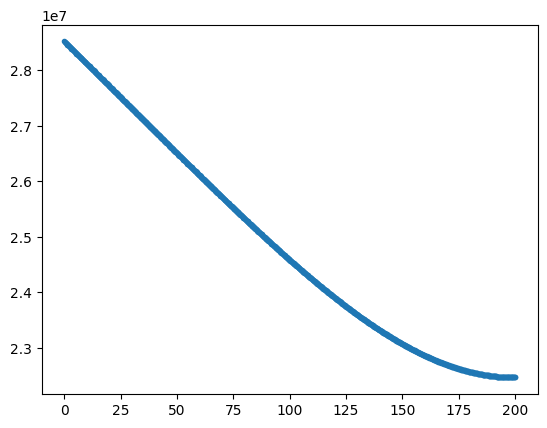